# 1. Исследовательский анализ данных

Found 7591 validated image filenames.
(32, 224, 224, 3)


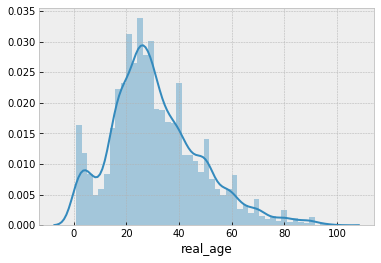

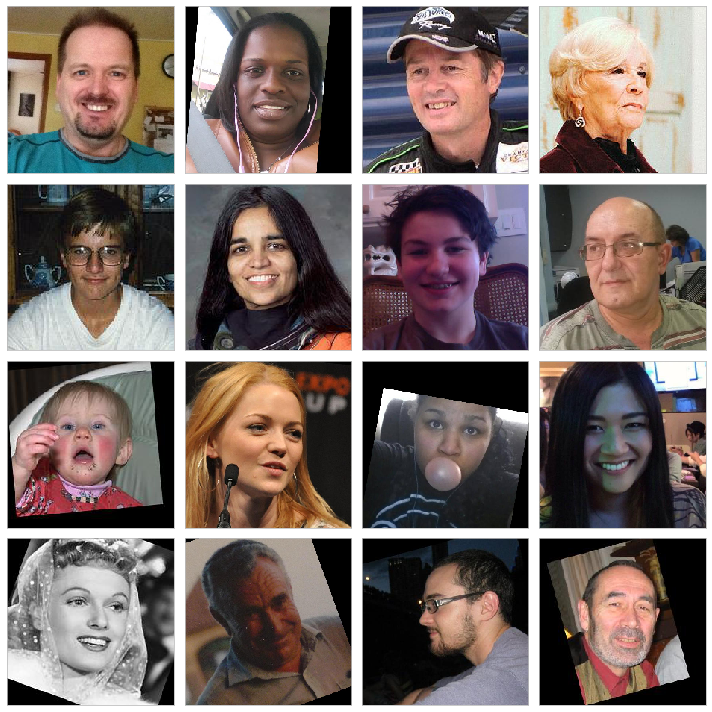

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg
import matplotlib.pyplot as plt


labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)


feautures, target = next(train_gen_flow)
print(feautures.shape)

plt.style.use('bmh')
sns.distplot(labels['real_age'])

fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(feautures[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Данных достаточно, так как мы видим что они покрывают практически весь возраст от 0 до 100 и так же видим нормальное распределение с мат ожидание 30 лет.

Аугметировать можно поворачивая фотографиии, так как видим в датасете много под углом и лишний черный фон

<span style="color:green">UPD 18.07.2020 Для задач компьютерного зрения объём данных для обучения маленький, но нам на помощь приходит предобученная нейросеть ResNet50 и аугментация. Распределение скорее скошено вправо. С остальным согласен.</span>

# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1/255.
                                       ,horizontal_flip = True
                                    # , vertical_flip = True
                                  # ,height_shift_range = 0.2, width_shift_range = 0.2
                                      )
    #valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip = True, vertical_flip = True)
    train_datagen_flow = train_datagen.flow_from_dataframe( dataframe = labels, directory = path + 'final_files/',
        x_col = 'file_name',
        y_col = 'real_age',
        target_size=(150, 150),
        batch_size=32,
        subset = 'training',
        class_mode='raw',
        seed=12345)
    return train_datagen_flow
def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(
                                    validation_split=0.25,
                                    rescale=1/255.
                                    #   ,horizontal_flip = True
                                    # , vertical_flip = True
                                  # ,height_shift_range = 0.2, width_shift_range = 0.2
                                      )
    test_datagen_flow = test_datagen.flow_from_dataframe( dataframe = labels, directory = path + 'final_files/',
            x_col = 'file_name',
            y_col = 'real_age',
            target_size=(150, 150),
            batch_size=32,
            subset = 'validation',
            class_mode='raw',
            seed=12345)
    return test_datagen_flow
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape = input_shape,
                    weights='imagenet',
                    include_top=False)
    #backbone.trainable = True
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    return model
def train_model(model, train_data, test_data, batch_size=None, epochs=5, #batch_size = 16
               steps_per_epoch=None, validation_steps=None):                          #steps_per_epoch = 1
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model



```

```

178/178 - 134s - loss: 298.2810 - mae: 12.4251 - val_loss: 927.3921 - val_mae: 25.6504
Epoch 2/5
178/178 - 38s - loss: 84.7050 - mae: 6.8979 - val_loss: 703.1437 - val_mae: 21.3131
Epoch 3/5
178/178 - 37s - loss: 55.2583 - mae: 5.6516 - val_loss: 277.5380 - val_mae: 12.5545
Epoch 4/5
178/178 - 38s - loss: 39.4111 - mae: 4.7484 - val_loss: 177.9604 - val_mae: 9.9973
Epoch 5/5
178/178 - 37s - loss: 29.4111 - mae: 4.0940 - val_loss: 96.8582 - val_mae: 7.6130
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 96.8582 - mae: 7.6130
Test MAE: 7.6130

```

# 3. Анализ обученной модели

Модель с линейной регресси показала, что ошибается где-то на 7 пунктов. И может определяь возраст с погрешностью в 7 лет